# Deep Neural Network with Tensorflow (All IBD)

This notebook implements a deep neural network model using TensorFlow to predict fatigue in IBD patients. Key components include:

- Data preprocessing and feature optimization for production deployment
- Train/validation/test split with GroupShuffleSplit to prevent data leakage
- Standardization of numerical features
- DNN architecture with 2 hidden layers (324 and 100 units) and dropout regularization
- Model training with early stopping based on validation loss
- Comprehensive evaluation metrics (accuracy, sensitivity, specificity, AUC, R2)
- SHAP analysis for model interpretability including:
  - Summary plots showing feature importance
  - Force plots for analyzing individual predictions
- Export functionality for production deployment including:
  - Trained model
  - Feature scaler
  - SHAP explainer
  - Evaluation metrics and plots

The model can be run on either the full IBD cohort or biochemical remission subset by setting `run_biochem_remission`.

In [1]:
import pandas as pd
import numpy as np
import shap
import json
import pickle
from joblib import dump
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
import datetime
from tensorflow.keras.metrics import AUC

from src.data.preprocessing import (
    load_and_preprocess_data,
    fix_numerical_features_for_production,
    remove_low_value_features,
)
from src.data.splitting import split_data_for_keras
from src.config.constants import NUMERICAL_FEATURES, RANDOM_SEED
from src.config.paths import DNN_DIR, DNN_BIOCHEM_REMISSION_DIR, ensure_output_dirs
from src.visualization.plotting import (
    plot_training_validation_auc,
    plot_training_validation_loss,
    plot_roc_curve,
    plot_confusion_matrix,
)

/Users/chershiongchuah/Developer/machine_learning_for_ibd_fatigue/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
ensure_output_dirs()

## Pipeline Configuration & Data Loading

In [3]:
random_seed = RANDOM_SEED  # Random seed to ensure reproducibility
run_biochem_remission = False  # Whether to use the biochem remission cohort
keras.utils.set_random_seed(random_seed)  # Set random seed for Keras

if run_biochem_remission:
    output_path = DNN_BIOCHEM_REMISSION_DIR
    cmap = "berlin"
    df = load_and_preprocess_data(biochemical_remission=True)
else:
    output_path = DNN_DIR

    # We save the medians to a file so that we can use them 
    # in the production pipeline to fill missing values on new data
    medians_path = DNN_DIR / "exports" / "medians.json"
    
    cmap = "seismic"
    df = load_and_preprocess_data(save_medians=True, medians_path=medians_path)

Median values saved to /Users/chershiongchuah/Developer/machine_learning_for_ibd_fatigue/output/all_ibd/dnn/exports/medians.json


## Optimise Features for Production

In [4]:
# We removed low value features here and simplified the model
df = remove_low_value_features(df)
numerical_features = NUMERICAL_FEATURES
numerical_features = fix_numerical_features_for_production(numerical_features)

## Split Data into Train, Validation and Test Sets

In [5]:
X_train, X_val, X_test, y_train, y_val, y_test, groups = split_data_for_keras(df)

print("Train shape:", X_train.shape)
print("Val shape:", X_val.shape)
print("Test shape:", X_test.shape)
print("Y train shape:", y_train.shape)
print("Y val shape:", y_val.shape)
print("Y test shape:", y_test.shape)

Train shape: (768, 65)
Val shape: (186, 65)
Test shape: (261, 65)
Y train shape: (768,)
Y val shape: (186,)
Y test shape: (261,)


## Scale Numerical Features

In [6]:
X_unified = pd.concat([X_train, X_val, X_test])
unified_scaler = StandardScaler()
unified_scaler.fit(X_unified[numerical_features])

X_train[numerical_features] = unified_scaler.transform(X_train[numerical_features])
X_test[numerical_features] = unified_scaler.transform(X_test[numerical_features])
X_val[numerical_features] = unified_scaler.transform(X_val[numerical_features])

## DNN Model Building


### Model Definition

In [7]:
model = keras.Sequential(
    [
        layers.Dense(324, activation="relu"),
        layers.Dropout(0.1),
        layers.Dense(100, activation="relu"),
        layers.Dropout(0.4),
        layers.Dense(1, activation="sigmoid"),
    ]
)

# log_dir = "logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=10, restore_best_weights=True
)

### Compile the Model

In [8]:
optimizer = keras.optimizers.RMSprop(learning_rate=0.0002)
model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=[AUC()])

In [9]:
history = model.fit(
    X_train,
    y_train,
    batch_size=32,
    epochs=100,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping_callback],
)

Epoch 1/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - auc: 0.5219 - loss: 0.7067 - val_auc: 0.6854 - val_loss: 0.6496
Epoch 2/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - auc: 0.7024 - loss: 0.6392 - val_auc: 0.7179 - val_loss: 0.6282
Epoch 3/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - auc: 0.7282 - loss: 0.6251 - val_auc: 0.7273 - val_loss: 0.6113
Epoch 4/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - auc: 0.7526 - loss: 0.6000 - val_auc: 0.7294 - val_loss: 0.6012
Epoch 5/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - auc: 0.7562 - loss: 0.5946 - val_auc: 0.7327 - val_loss: 0.5942
Epoch 6/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - auc: 0.7741 - loss: 0.5759 - val_auc: 0.7368 - val_loss: 0.5887
Epoch 7/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - auc: 0.7808 - loss: 0.5674 - val_auc: 0.7432 - val_loss: 0.5844
Epoch 8/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - auc: 0.7907 - loss: 0.5567 - val_auc: 0.7478 - val_loss: 0.5801
Epoch 9/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - auc: 0.7797

In [10]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (32, 324)              │        21,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (32, 324)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 100)              │        32,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (32, 100)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (32, 1)                │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 107,972 (421.77 KB)

 Trainable params: 53,985 (210.88 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 53,987 (210.89 KB)

In [11]:
history_dict = history.history
history_dict.keys()

dict_keys(['auc', 'loss', 'val_auc', 'val_loss'])

### Training Plots

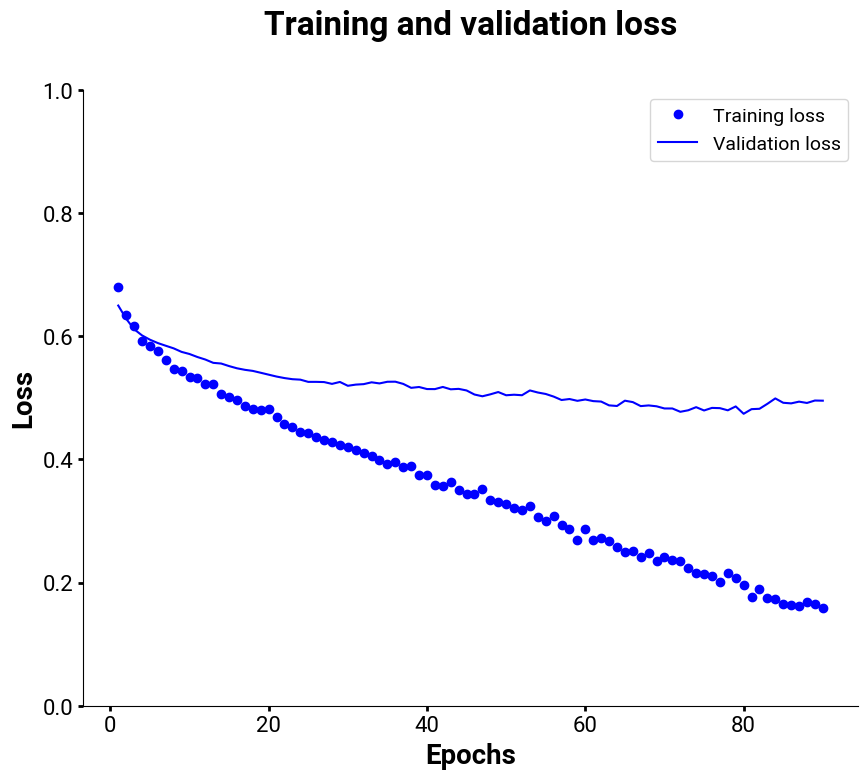

In [12]:
save_path = output_path / "plots" / "training_validation_loss.png"
plot_training_validation_loss(history_dict, save_path)

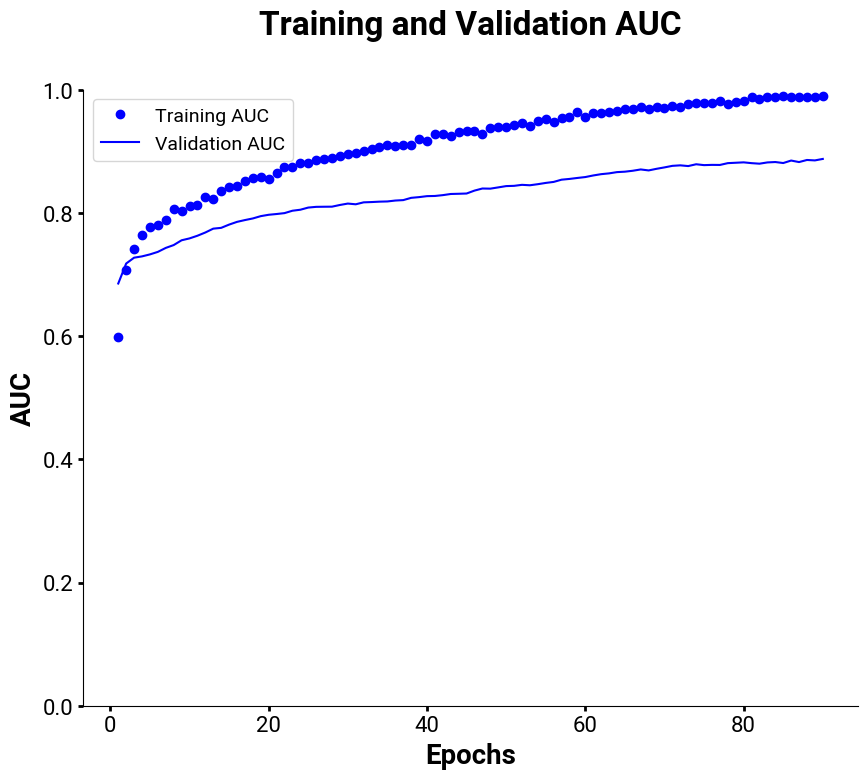

In [13]:
save_path = output_path / "plots" / "training_validation_auc.png"
plot_training_validation_auc(history_dict, save_path)

## Model Evaluation

In [14]:
results = model.evaluate(X_test, y_test)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - auc: 0.9023 - loss: 0.4141


### Metrics

In [15]:
from sklearn.metrics import (
    roc_curve,
    roc_auc_score,
    confusion_matrix,
    accuracy_score,
    recall_score,
    r2_score,
)

y_pred = model.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
test_auc = roc_auc_score(y_test, y_pred)

y_classes = np.where(y_pred > 0.5, 1, 0)

tn, fp, fn, tp = confusion_matrix(y_test, y_classes).ravel()

# Calculate metrics
accuracy = accuracy_score(y_test, y_classes)
sensitivity = recall_score(y_test, y_classes)  # TPR
specificity = tn / (tn + fp)  # TN

r2 = r2_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Sensitivity:", sensitivity)
print("Specificity:", specificity)
print("AUC:", test_auc)
print("R2:", r2)

metrics_dictionary = {
    "accuracy": accuracy,
    "sensitivity": sensitivity,
    "specificity": specificity,
    "auc": test_auc,
    "r2": r2,
}

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Accuracy: 0.8582375478927203
Sensitivity: 0.8316831683168316
Specificity: 0.875
AUC: 0.8991955445544555
R2: 0.5236821174621582


In [16]:
# Calculate Cox-Snell R² (based on deviance/likelihood)
def cox_snell_r2(y_true, y_pred_prob):
    y_pred_prob = y_pred_prob.flatten()
    # Small epsilon to avoid log(0)
    eps = 1e-15
    y_pred_prob = np.clip(y_pred_prob, eps, 1-eps)
    
    # Log-likelihood for the fitted model
    ll_model = np.sum(
        y_true * np.log(y_pred_prob) + 
        (1 - y_true) * np.log(1 - y_pred_prob)
    )
    
    # Log-likelihood for the null model (just predicting mean)
    y_mean = np.mean(y_true)
    y_mean = np.clip(y_mean, eps, 1-eps)
    ll_null = np.sum(
        y_true * np.log(y_mean) + 
        (1 - y_true) * np.log(1 - y_mean)
    )
    
    # Calculate Cox-Snell R²
    n = len(y_true)
    return 1 - np.exp(-2/n * (ll_model - ll_null))

# Calculate and add to metrics
cs_r2 = cox_snell_r2(y_test, y_pred)
print(f"Cox-Snell R²: {cs_r2:.4f}")
print(f"Standard R²: {r2:.4f}")

# Add to metrics dictionary
metrics_dictionary["cox_snell_r2"] = float(cs_r2)

Cox-Snell R²: 0.3735
Standard R²: 0.5237


### Confusion Matrix

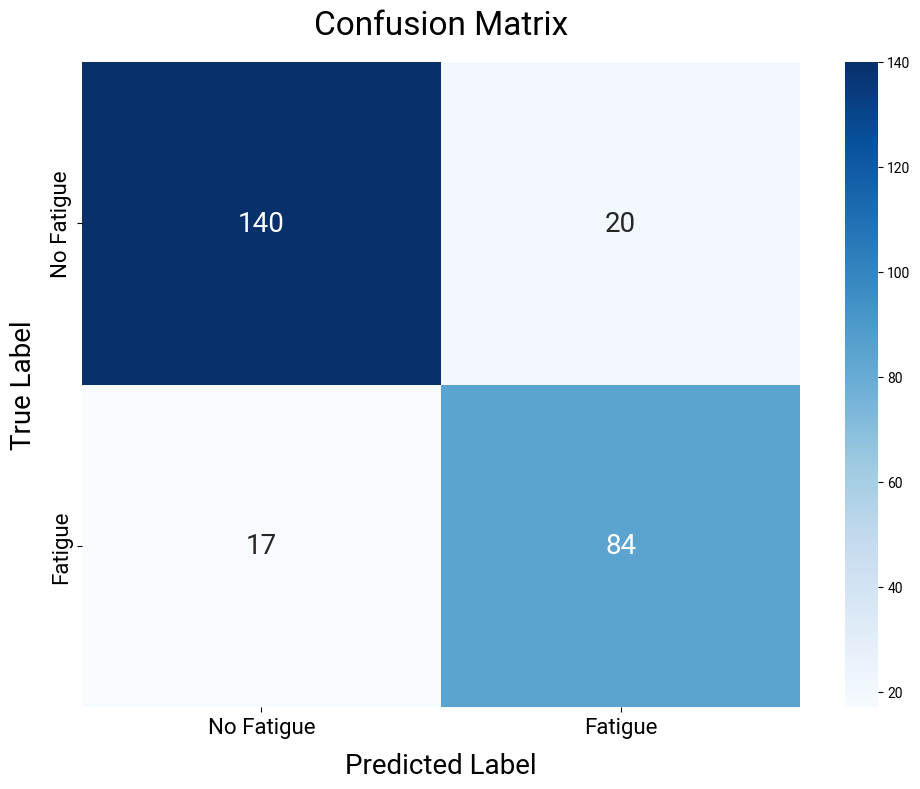

In [17]:
save_path = output_path / "plots" / "confusion_matrix.png"
plot_confusion_matrix(y_test, y_classes, save_path)

### ROC Curve

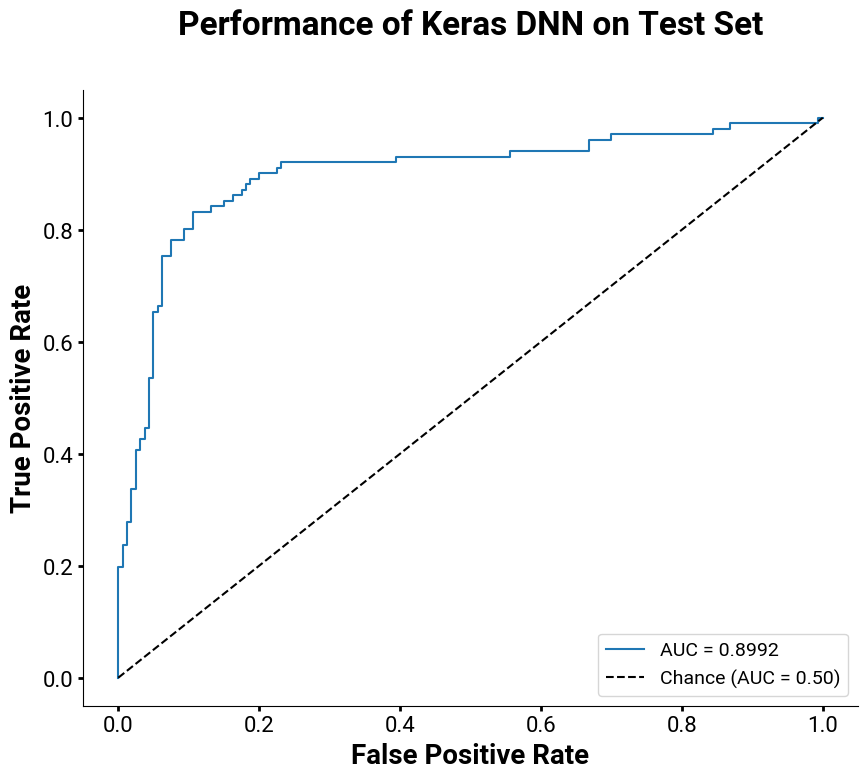

In [18]:
save_path = output_path / "plots" / "roc_curve.png"
plot_roc_curve(fpr, tpr, test_auc, save_path)

### Export Metrics

In [19]:
save_path = output_path / "metrics" / "dnn_metrics.json"
with open(save_path, "w") as f:
    json.dump(metrics_dictionary, f)

np.savetxt(output_path / "metrics" / "dnn_fpr.txt", fpr)
np.savetxt(output_path / "metrics" / "dnn_tpr.txt", tpr)

## SHAP Analysis

In [20]:
# Clean Column Names for Graphs

X_test_clean_columns = [
    col.replace("montreal_cd_location_", " ") for col in X_test.columns
]
X_test_clean_columns = [col.replace("_", " ") for col in X_test_clean_columns]
X_test_clean_columns = [
    col.replace("montreal uc extent ", "") for col in X_test_clean_columns
]
X_test_clean_columns = [
    col.replace("montreal uc severity ", "") for col in X_test_clean_columns
]
X_test_clean_columns = [
    col.replace("montreal cd behaviour ", "") for col in X_test_clean_columns
]
X_test_clean_columns = [col.replace("is smoker ", "") for col in X_test_clean_columns]
X_test_clean_columns = [col.replace("name ", "") for col in X_test_clean_columns]
# to title case
X_test_clean_columns = [col.title() for col in X_test_clean_columns]
replacements = {
    "Uc": "UC",
    "Cd": "CD",
    "Ibdu": "IBDU",
    "Bmi": "BMI",
    "Crp": "CRP",
    "Gi": "GI",
}

for old, new in replacements.items():
    X_test_clean_columns = [col.replace(old, new) for col in X_test_clean_columns]
print(X_test_clean_columns)

['Age', 'Sex', 'Height', 'Weight', 'BMI', 'Age At Diagnosis', 'Montreal Upper GI', 'Montreal Perianal', 'Has Active Symptoms', 'Albumin', 'CRP', 'Haemoglobin', 'Red Cell Count', 'White Cell Count', 'Neutrophils', 'Lymphocytes', 'Monocytes', 'Eosinophils', 'Basophils', 'Platelets', 'Urea', 'Creatinine', 'Sodium', 'Potassium', 'Calprotectin', 'Sampling Steroids', 'Sampling Abx', 'Sampling Asa', 'Sampling Aza', 'Sampling Mp', 'Sampling Ifx', 'Sampling Ada', 'Sampling Vedo', 'Sampling Uste', 'Sampling Tofa', 'Sampling Mtx', 'Sampling Ciclosporin', 'Sampling Filgo', 'Sampling Upa', 'Sampling Risa', 'Disease Duration Weeks', 'Diagnosis Year', 'Study Group CD', 'Study Group IBDU', 'Study Group UC', ' L1 Ileal', ' L2 Colonic', ' L3 Ileocolonic', 'B1 Non-Stricturing, Non-Penetrating', 'B2 Stricturing', 'B3 Penetrating', 'E1 Proctitis', 'E2 Left-Sided', 'E3 Extensive', 'S0 Remission', 'S1 Mild', 'S2 Moderate', 'S3 Severe', 'Ex-Smoker', 'Non-Smoker', 'Smoker', 'Season Autumn', 'Season Spring', 'S

### Explainer and SHAP Values Computation

In [21]:
explainer = shap.KernelExplainer(
    model, shap.sample(X_train, 200, random_state=random_seed)
)
shap_values = explainer.shap_values(X_test)
shap_values_class_1 = shap_values[:, :, 0]  # collapses 3d array to 2d

Using 200 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
100%|██████████| 261/261 [03:19<00:00,  1.31it/s]


### Summary Plots

In [22]:
shap.initjs()

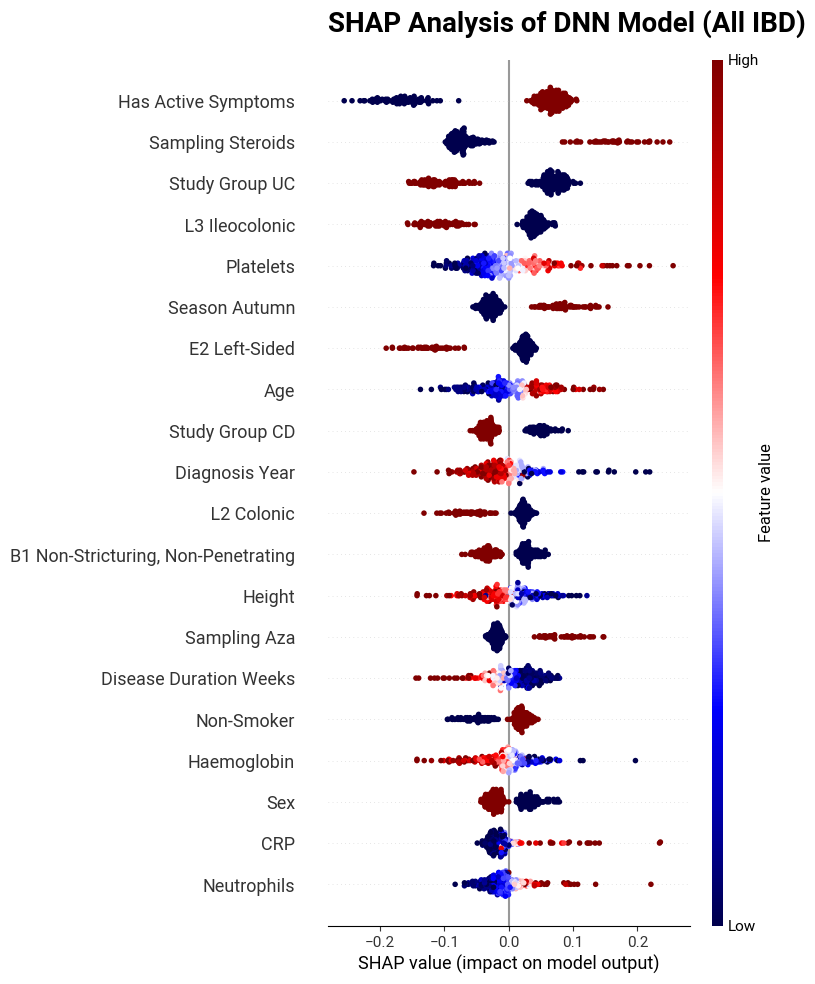

In [23]:
shap.summary_plot(
    shap_values_class_1,
    X_test,
    feature_names=X_test_clean_columns,
    show=False,
    cmap=cmap,
)
if run_biochem_remission:
    plt.title(
        "SHAP Analysis of DNN Model (Biochem Remission)",
        fontsize=20,
        pad=20,
        loc="left",
        fontweight="bold",
    )
else:
    plt.title(
        "SHAP Analysis of DNN Model (All IBD)",
        fontsize=20,
        pad=20,
        loc="left",
        fontweight="bold",
    )

save_path = output_path / "plots" / "shap_dnn_summary_plot.png"
plt.savefig(save_path, dpi=300, bbox_inches="tight")
plt.show()

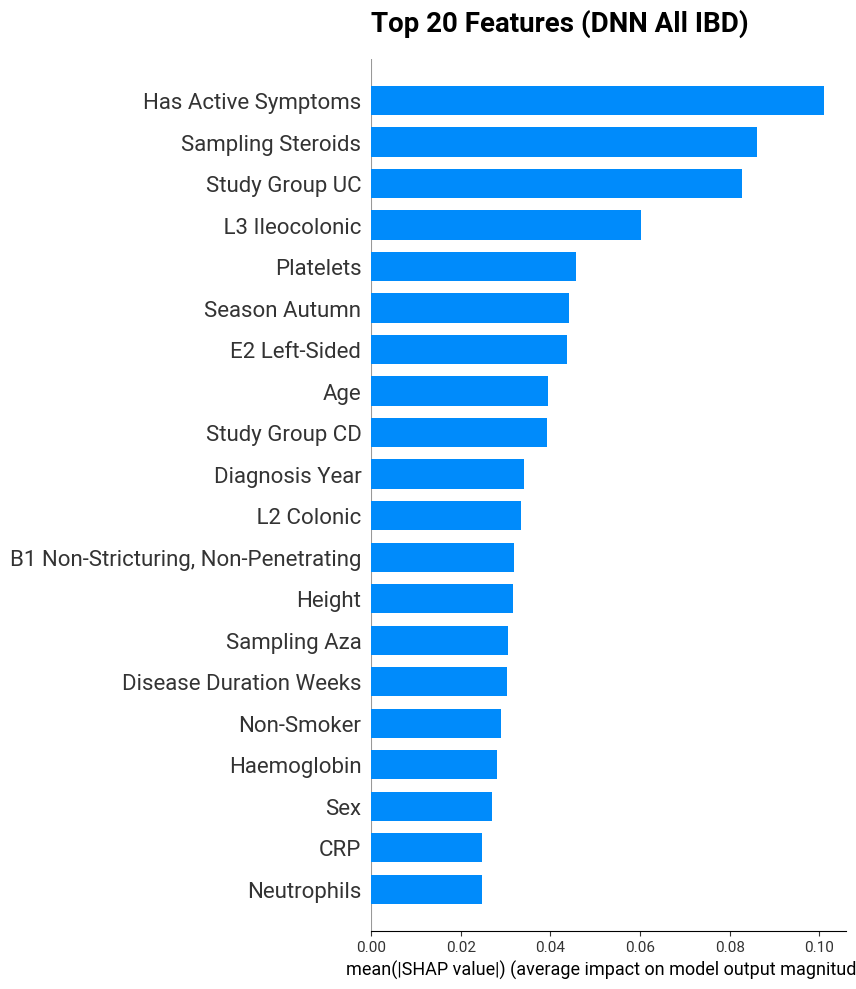

In [24]:
shap.summary_plot(
    shap_values_class_1,
    X_test,
    feature_names=X_test_clean_columns,
    show=False,
    cmap=cmap,
    plot_type="bar",
    max_display=20,
)

if run_biochem_remission:
    plt.title(
        "Top 20 Features (DNN Biochem Remission)",
        fontsize=20,
        pad=20,
        loc="left",
        fontweight="bold",
    )
else:
    plt.title(
        "Top 20 Features (DNN All IBD)",
        fontsize=20,
        pad=20,
        loc="left",
        fontweight="bold",
    )
plt.yticks(fontsize=16)

save_path = output_path / "plots" / "shap_dnn_feature_bar_plot.png"
plt.savefig(save_path, dpi=300, bbox_inches="tight")
plt.show()

### Forceplots

In [25]:
# Revert scaled features to original values
X_test_reverted = X_test.copy()
X_test_reverted[numerical_features] = unified_scaler.inverse_transform(
    X_test[numerical_features]
).round(2)

In [26]:
# Create prediction groups based on true and predicted values
predictions_df = pd.DataFrame(
    {"true": y_test, "pred": y_classes.ravel()}, index=y_test.index
)

# Split into TP, TN, FP, FN groups
true_positives = predictions_df[
    (predictions_df["true"] == 1) & (predictions_df["pred"] == 1)
]
true_negatives = predictions_df[
    (predictions_df["true"] == 0) & (predictions_df["pred"] == 0)
]
false_positives = predictions_df[
    (predictions_df["true"] == 0) & (predictions_df["pred"] == 1)
]
false_negatives = predictions_df[
    (predictions_df["true"] == 1) & (predictions_df["pred"] == 0)
]


In [27]:
shap_values_df = pd.DataFrame(shap_values_class_1, index=y_test.index)

In [28]:
# Create dictionary of prediction groups and their data
MIN_NUMBER_OF_PLOTS = 30

prediction_groups = {
    "true_positive": (true_positives, MIN_NUMBER_OF_PLOTS),
    "true_negative": (true_negatives, MIN_NUMBER_OF_PLOTS),
    "false_positive": (false_positives, MIN_NUMBER_OF_PLOTS),
    "false_negative": (false_negatives, MIN_NUMBER_OF_PLOTS),
}

In [29]:
# Print summary statistics
print("\nPrediction Group Sizes:")
for group_name, (group_df, _) in prediction_groups.items():
    print(f"{group_name}: {len(group_df)} cases")


Prediction Group Sizes:
true_positive: 84 cases
true_negative: 140 cases
false_positive: 20 cases
false_negative: 17 cases


In [30]:
def generate_forceplot(shap_values, X_data, expected_value, save_path):
    """Generate and save SHAP force plot for a single prediction"""
    shap.force_plot(
        expected_value,
        shap_values,
        X_data,
        matplotlib=True,
        contribution_threshold=0.05,
        text_rotation=30,
        show=False,
    )
    plt.savefig(save_path, dpi=150, bbox_inches="tight")
    plt.close()


# Generate force plots for each group
for group_name, (group_df, n_plots) in prediction_groups.items():
    if len(group_df) > 0:
        # Get data and SHAP values for this group
        X_group = X_test_reverted.loc[group_df.index].reset_index(drop=True)
        shap_values_group = shap_values_df.loc[group_df.index].to_numpy()

        # Generate plots
        n_plots = min(
            n_plots, len(group_df)
        )  # Ensure we don't exceed available samples
        for i in range(n_plots):
            save_path = output_path / "plots" / "forceplots" / f"{group_name}_{i}.png"
            generate_forceplot(
                shap_values_group[i],
                X_group.iloc[i],
                explainer.expected_value[0],
                save_path,
            )

In [31]:
# Export prediction dataframes for further analysis
for group_name, (group_df, _) in prediction_groups.items():
    if len(group_df) > 0:
        export_df = group_df.join(X_test_reverted)
        export_path = output_path / "evaluation" / f"{group_name}_predictions.csv"
        export_df.to_csv(export_path, index=True)

## Production Exports

In [32]:
today = datetime.datetime.now().strftime("%Y-%m-%d")

dump(unified_scaler, output_path / "exports" / f"scaler_{today}.pkl")
X_test.to_csv(output_path / "exports" / "X_test.csv", index=False)
model.save(output_path / "exports" / f"IFM-1_{today}.keras")
with open(output_path / "exports" / f"shap_explainer_{today}.pkl", "wb") as f:
    pickle.dump(explainer, f)